# RL Notes 3: Exploration vs Exploitation

Blog post (including type fix) [here](https://krisztiankovacs.com/rl-notes-3-exporation-vs-exploitation/).

Until now, we used environments were had perfect information: we knew the rewards and transition probabilities. In those context, we could use policy or value iteration to find our optimal policy.

Of course, the interesting case is when we don't have any information whatsoever. We don't know the transition probabilities, and we may not even know the rewards.

Let's briefly review our setting. We're playing a game. This game has certain states we can be in, and actions we can take. We don't know the result of an action. Sometimes we get a reward. We don't know when this happens, but we want more them. 

How do we solve situations like this? We solve them by repeatedly simulating the environment. We use our results estimate the unknown quantities (the fancy name for this technique is Monte Carlo methods).

I discuss some concrete strategies below, but one theme will be common to them all:

### The exploration-exploitation dilemma

At any point we have two options available to us: we can **explore** the possibilities we have, or we can **exploit** the policy we judged so far to be the best. Most strategies will start with exploration in the beginning so that we can gather information. As we do so, we gradually shift towards exploitation of the strategy we judged to be the best.

If we keep on exploring for too long, we waste valuable opportunities to collect rewards.

If we exploit too early, we may be locked into a sub-optimal solution -- had we gathered more information, we could have discovered a better policy.

### Strategies illustrated here

In this post, I will discuss the following, very common policies:
- Greedy
- Explore First, then Greedy,
- Epsilon-Greedy
- Optimistic Initialization
- Optimism in the Face of Uncertainty
- Thompson Sampling

### The Q Function

Many policies will refer in one way or another to the Q function. This function maps state-action combinations to average returns. It is basically a big lookup table.

## The Environment: Cheating Roulette

### Openai's simple roulette

Openai contains a simplified roulette environment. The rules are as follows:
- You have a roulette wheel with numbers 0-36.
- Every round you can select a number, or you can leave the roulette table, ending the game.
- If you select 0, and it comes up, you receive \$36. If it doesn't come up, you loose \$1.
- If you select a non-zero number, you receive \$1 if the parity of your number matches the parity of the roll (0 doesn't count). Otherwise, you loose \$1. Example: if you select 5 and 17 is rolled you receive \$1.
- Each number has the same probability of showing up.

Simple math will tell you that this roulette has a negative expected value (just as in real life). The best action the agent can take is simply leave the table (again, as in real life).

In [1]:
#!pip install pyglet==1.2.4
#!pip install gym

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import gym

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

In [4]:
gym.make('Roulette-v0')  # Openai's original roulette

<TimeLimit<RouletteEnv<Roulette-v0>>>

### Cheating roulette modification

That's not a very interesting setting however. So we will modfiy this roulette. In particular, we will change it so that
- 0 has a 0.033 probability of showing up (instead of ~0.027).
- Every other number is equally likely.
- The payoff is the same as in the original roulette.

The effect of this change is that playing **0** has now positive expected value. However, it is extremely difficult to find out about this feature. After all, even with the modification, 0 will only be rolled once in 30 rounds (on average). 

Moreover, not knowing the **0** cheat (playing policies randomly), the expected value is still negative. That makes leaving the table still attractive, although in this case, suboptimal.

Basically, I have set up an environment where it is easy for an agent to get trapped in a sub-optimal solution (leaving the table).

In [5]:
class CheatingRoulette(gym.envs.toy_text.RouletteEnv):
    '''A modification of the original openai Roulette environment. 
    Here, 0 has positive expected value.'''
    def step(self, action):
        assert self.action_space.contains(action)
        if action == self.n - 1:
            # observation, reward, done, info
            return 0, 0, True, {}

        if np.random.rand() < 0.033:  # Implement cheating
            val = 0
        else:     
            val = self.np_random.randint(1, self.n - 1)
        if val == action == 0:
            reward = self.n - 2.0
        elif val != 0 and action != 0 and val % 2 == action % 2:
            reward = 1.0
        else:
            reward = -1.0
        return 0, reward, False, {}

### The Simulations

I will consider to be a game of roulette to be 100 rounds. The aim is to maximize the money an agent makes in these 100 rounds.

Each strategy will play 10 000 games (each 100 rounds). After each game, the agent will be able to update its policy.  (Why not update after each round? Because that would dramatically increase computation time, as some strategies rely on the entire history of the game.)

In [6]:
ENV = CheatingRoulette()
GAMMA = 0.5  # Low discount factor, as I want to emphasize the immediate rewards.
SIMS = 10000 # Number of simulations

## The Policies

Below I create a class that serves as a container for the different policies, defining the common functions among all of them. It contains quite a few lines of code, but will make defining policies much simpler later on.

In [7]:
class Policy(object):
    '''This class is a container for the different policies.
    
    Note: In roulette, states don't matter (and in the openai case, there is
    only 1 state). I still index relevant quantities by state though (for
    example, the Q function), so that this code can easily be extended for other
    environments.
    '''    
    
    def pi(self):
        '''Each policy will have to define this function'''
        raise NotImplementedError
    
    def __init__(self, first_visit = False):
        '''If first_visit is True, returns are updated using first-visit MC,
        otherwise by every-visit MC.'''
        self.first_visit = first_visit
        self.env = ENV
        self.resetAll()   
            
    def next_action(self):
        '''Perform the next action according to policy. Update variables.'''
        self.old_state = self.state
        self.action = self.pi()
        self.action_list[self.episode].append(self.action)
        self.state, self.reward, self.done, _ = self.env.step(self.action)
        self.current_total += self.reward
        self.states_actions_rewards.append((self.old_state, self.action, self.reward))
        self.callOnActionEnd()
        
    def playGame(self):
        '''Plays roulette for 100 rounds. This will be considered 1 game.'''
        self.resetGame()        
        for i in range(100):  # play 100 rounds
            self.current_round += 1
            self.next_action()
            if self.done:
                break
        self.updateReturns()
        self.updateQ()
        self.callOnEnd()
        self.episode += 1
        
    def simPolicy(self, n = 10000):
        '''Plays n games of roulette, outputs a list of total rewards.'''
        res = []
        for i in range(n):
            if i % 1000 == 0:
                print('.', end = '')
            self.playGame()
            res.append(self.current_total)
        print('\n')
        return np.array(res)
        
    def resetAll(self):
        '''Reset all variables to default, thereby clearing game history.'''
        self.nA = self.env.action_space.n  # Number of actions
        self.nS = self.env.observation_space.n  # Number of states. For roulette, 1.
        self.episode = 0  # Number of games played (each with 100 rounds)
        self.returns = {}  # Return, given state and action
        # I initialize Q to be random small numbers, as opposed to 0.
        # The reason: Otherwise the argmax function always takes the smallest, giving
        # 0 an unfair edge in the beginning.
        self.Q = 2*np.random.rand(self.nS, self.nA) - 1  # Between -1 and 1
        self.Q[0, 37] = 0  # The value for leaving the game is known to be 0.
        for s in range(self.nS):
            for a in range(self.nA):
                self.returns[(s, a)] = []
        self.action_list = []
        self.resetGame()
    
    def resetGame(self):
        '''Resets a single game (but doesn't delete information from game history)'''
        self.state = self.env.reset()
        self.reward = 0
        self.current_round = 0
        self.current_total = 0
        self.done = False
        self.states_actions_rewards = []
        self.states_actions_returns = []
        self.action_list.append([])
        
    def callOnEnd(self):
        '''Optional function that is executed at the end of each game.
        Usually related to updating strategy.'''
        pass
    
    def callOnActionEnd(self):
        '''Optional function that is executed at the end of each action step.'''
        pass
        
    def getStateActionReturns(self):
        '''Calculates the state_action_returns for a single game.'''
        G = 0
        for state, action, reward in reversed(self.states_actions_rewards):
            G = reward + GAMMA * G
            self.states_actions_returns.append((state, action, G))
            
    def updateReturns(self):
        '''Appends returns with the results from the current state_action_returns.
        First-visit and every-visit MC are both possible.'''
        self.getStateActionReturns()
        seen_state_action_pairs = set()
        for state, action, G in self.states_actions_returns:
            sa = (state, action)
            if not self.first_visit or (sa not in seen_state_action_pairs):
                self.returns[sa].append(G)
                seen_state_action_pairs.add(sa)
        
    def updateQ(self):
        '''Updates our Q function (showing the average return of a state-action combo)'''
        for s in range(self.nS):
            for a in range(self.nA):
                if not self.returns[(s, a)] == []:
                    self.Q[s, a] = np.mean(self.returns[(s, a)])
                    
    def getMaxQ(self):
        '''Returns action with the highest average Q value (highest average return)'''
        return np.argmax(self.Q[self.state, :])

In [8]:
def plotRun(res, title = 'Title', k=5, plot_avg = False):
    x = list(range(len(res)))
    run_avg = list(res[:(k-1)]) + [np.mean(res[i:(i+5)]) for i in range(len(res)-k+1)]
    fig = plt.figure(figsize = (10, 5))
    plt.scatter(x, res, marker = '.')
    if plot_avg: plt.plot(x, run_avg, color = 'black')   
    plt.title(f'Average Profit per Game: {np.mean(res)}')
    plt.suptitle(title)
    
def getResults(pol, title, sims = SIMS):
    res = pol.simPolicy(sims)
    plotRun(res, title)
    
def plotActions(pol, ints = [[0, 1000], [9000, 10000]]):
    legend = [f'Round {sub[0]} - {sub[1]}' for sub in ints]
    l0 = [item for sublist in pol.action_list[ints[0][0]:ints[0][1]] for item in sublist]
    l1 = [item for sublist in pol.action_list[ints[1][0]:ints[1][1]] for item in sublist]
    labels = [legend[0]]*len(l0) + [legend[1]]*len(l1)
    df = pd.DataFrame({'Actions':l0+l1, 'Round':labels})
    print('Actions taken by agent in different rounds')
    axes = df.hist('Actions', by = 'Round', layout = (1, 3), figsize = (15, 3), bins = pol.nA)
    plt.show()

### Basic Benchmark Policies

Before we discuss the strategies listed above, let's have some useful benchmarks.

The first option is to always leave the table; never play. Obviously, that will have a return of 0.

..........



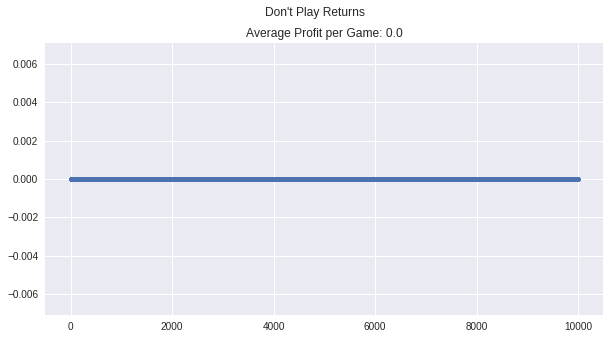

In [9]:
class DontPlay(Policy):      
    def pi(self):
        return 37  # This action is leaving the table
pol = DontPlay()
getResults(pol, "Don't Play Returns")
del(pol)

More interestintly, what if we play in 'God mode', knowing the **0** cheat? In that case, we will earn, on average, about \$22 per game (per 100 rounds).

Below is a plot of the money we earn in each simulated round. Note that even knowing the cheat, in most games we still loose money, as we need 4 zeros per game to get a positive profit. Our positive average is due to the few games where zeros came up many times.

In [10]:
class OptimalPlay(Policy):
    def pi(self):
        return 0

..........



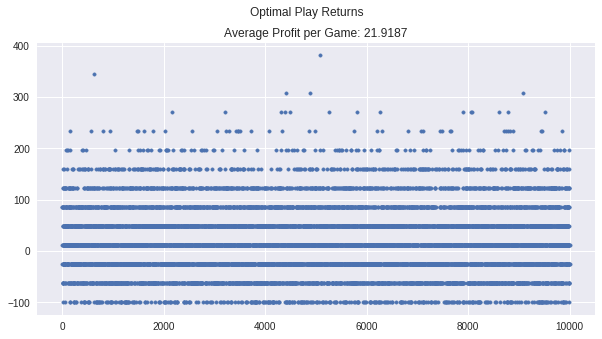

In [11]:
pol = OptimalPlay()
getResults(pol, "Optimal Play Returns")
del(pol)

Just to check, what happens if we always select a random number? The return is somewhat negative: we loose money on average, about \$1 per game (per 100 rounds). 

In [12]:
class RandPolicy(Policy):
    
    def pi(self):
        return self.env.action_space.sample()

..........



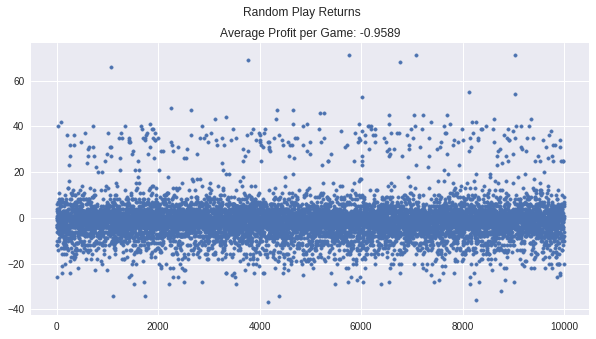

In [13]:
pol = RandPolicy()
getResults(pol, "Random Play Returns")
del(pol)

### Greedy Policy

Our simplest policy is a greedy policy.  A greedy policy simply plays the number with the highest Q value, in this case, with the highest historical return. Generally, it's not a good choice, as it may lock into a sub-optimal solution. (There is a chance that the greedy policy will find the optimal solution, just not a reliably big one.)

Benefits
- Easy to implement, easy to explain.
- No hypterparameters to tune.

Drawbacks
- No exploration, often gets stuck at sub-optimal play.

In [14]:
class Greedy(Policy):

    def pi(self):
        return self.getMaxQ()   

..........



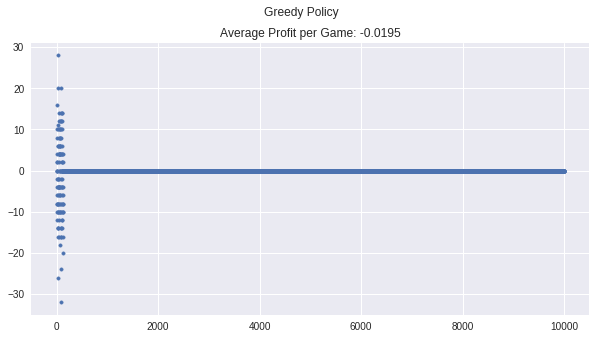

In [15]:
pol = Greedy()
getResults(pol, "Greedy Policy")

As we can see, for the first couple of rounds our policy followed some random choices, as some numbers, just by chance, got positive rewards. However, very quickly our policy concludes that it's best to leave the game - and earns 0 rewards afterward.

Actions taken by agent in different rounds


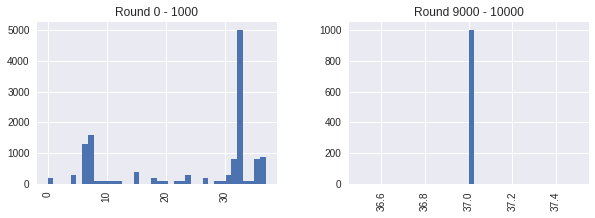

In [16]:
plotActions(pol)

In [17]:
del(pol)

## Explore First Then Greedy

Since the our greedy policy had the drawback of not doing enough exploration, let's add explicit exploration rounds.

We will let our policy follow random actions for the first **k** games. After **k** games, it will follow a greedy policy.

Benefits
- Simple to implement and explain.
- Includes both exploration and exploitation.

Drawbacks
- Need to choose k manually.
- It is a priori unclear how much exploration/exploitation one should do in a given game.
- Exploration isn't done intelligently, it just chooses random actions.

In [18]:
class ExpFirst(Policy):
    
    def __init__(self, exp_num):
        super().__init__()
        self.exp_num = exp_num
    
    def pi(self):
        if self.episode <= self.exp_num:
            # Do exploration
            return self.env.action_space.sample()
        else:
            # Do exploitation
            return self.getMaxQ()         

In this example, we explore for the first 1000 rounds. In this particular case, it managed to find the best policy afterwards. Note however that there is still luck involved, and there is no guarantee that if we replay the same policy it will find the optimum again (it depends on how often 0 land in the first 1000 rounds).

..........



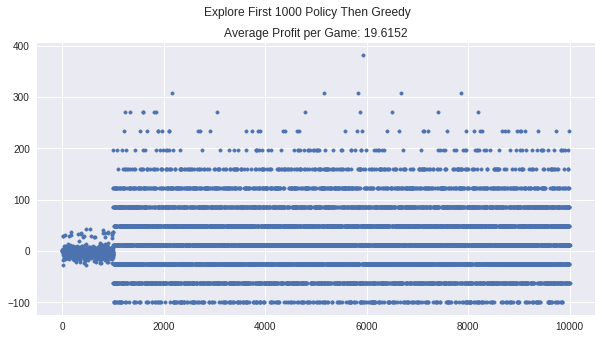

In [19]:
pol = ExpFirst(1000)
getResults(pol, "Explore First 1000 Policy Then Greedy")

Actions taken by agent in different rounds


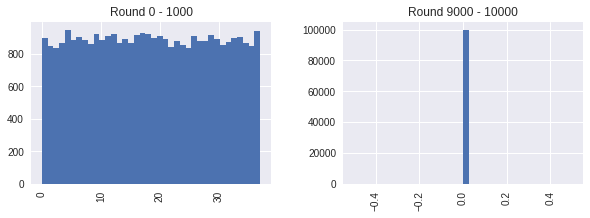

In [20]:
plotActions(pol)

In [21]:
del(pol)

..........



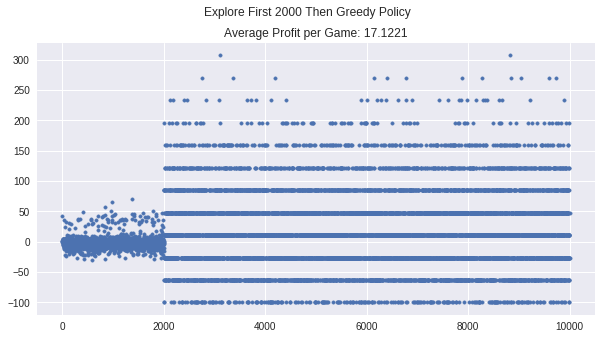

In [22]:
pol = ExpFirst(2000)
getResults(pol, "Explore First 2000 Then Greedy Policy")

Actions taken by agent in different rounds


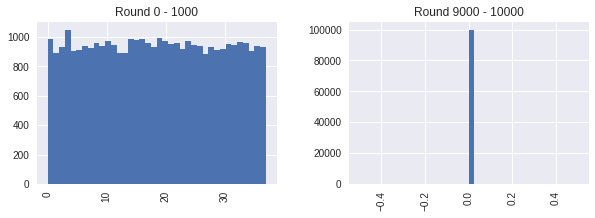

In [23]:
plotActions(pol)

In [24]:
del(pol)

Another pitfall: exploring too long. Here we explore for 5000 rounds (half the time) before exploiting. This means we are more likely going to find the optimal policy, but we reduce our exploitation opportunities: our average profit is little more than half than in the first case.

..........



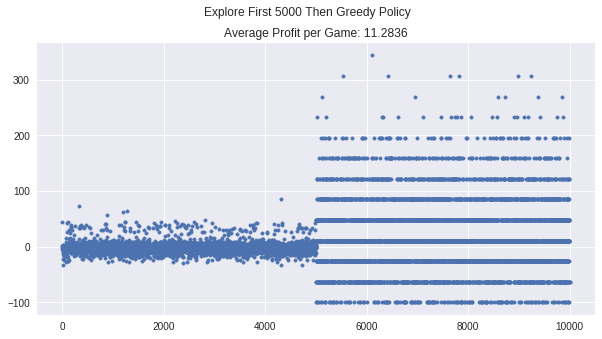

In [25]:
pol = ExpFirst(5000)
getResults(pol, "Explore First 5000 Then Greedy Policy")

Actions taken by agent in different rounds


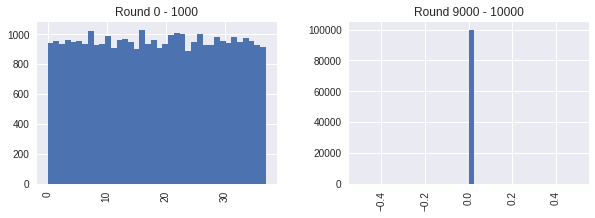

In [26]:
plotActions(pol)

In [27]:
del(pol)

## Epsilon-Greedy

Another way to modify the pure greedy strategy is to add some noise to it. Specifically, follow the greedy strategy with probability $(1-\epsilon)$, and do a random action with probability $\epsilon$.

Over time, we want to decrease $\epsilon$, so that we gradually shift from exploration to exploitation. One possibility is to express it as:

$ \epsilon = \frac{k}{n}$

where n is the number of games we played so far. 

Benefits
- Still relatively simple to implement and explain.
- Even if it gets stuck at a suboptimal solution, it has the chance to 'break out'.
- May adopt to changing environments.

Drawbacks
- Unintelligent exploration
- Need to choose hyper-parameters well.

In [28]:
class EpsGreedy(Policy):
    
    def __init__(self, k):
        super().__init__()
        self.k = k
    
    def pi(self):
        epsilon = self.k / max(self.episode, 1)
        if np.random.rand() <= epsilon:
            # Do exploration
            return self.env.action_space.sample()
        else:
            # Do exploitation
            return self.getMaxQ()

..........



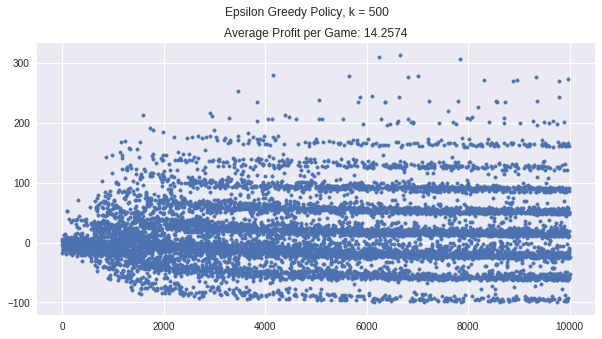

In [29]:
pol = EpsGreedy(500)
getResults(pol, "Epsilon Greedy Policy, k = 500")

Actions taken by agent in different rounds


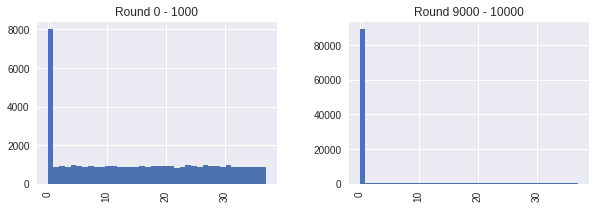

In [30]:
plotActions(pol)

In [31]:
del(pol)

A demonstration of the luck involved: even though we explore twice as long as in the previous case, we were unlucky and didn't find the optimal solution.

..........



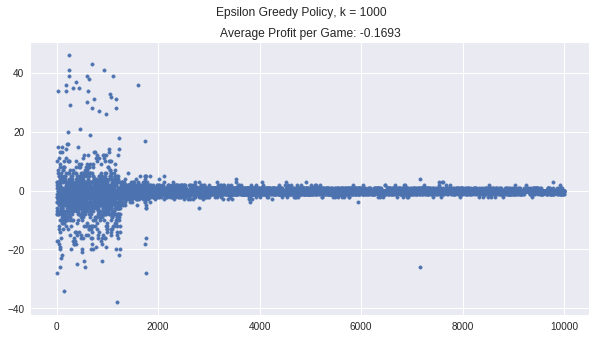

In [32]:
pol = EpsGreedy(1000)
getResults(pol, "Epsilon Greedy Policy, k = 1000")

Actions taken by agent in different rounds


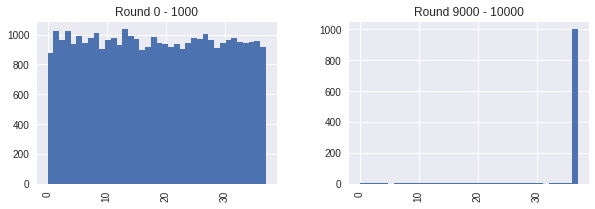

In [33]:
plotActions(pol)

In [34]:
del(pol)

More exploration. We find the optimum, but reduced our profit by exploring too long.

..........



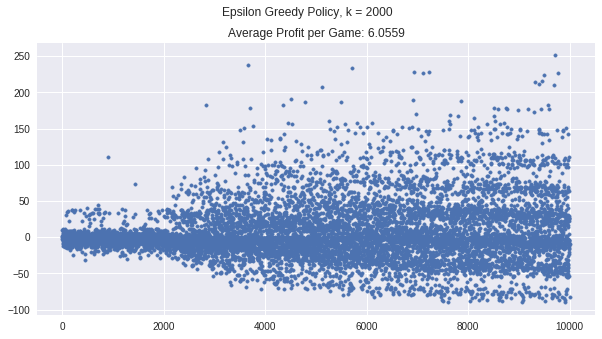

In [36]:
pol = EpsGreedy(2000)
getResults(pol, "Epsilon Greedy Policy, k = 2000")

Actions taken by agent in different rounds


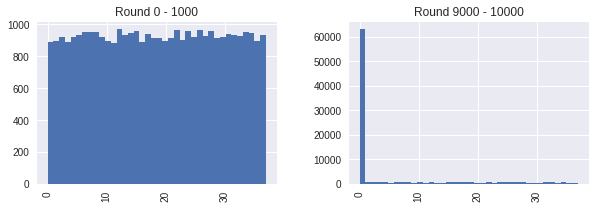

In [37]:
plotActions(pol)

In [38]:
del(pol)

## Optimistic Initialization

This is not so much a stand-alone strategy, as it is a hack on our greedy policy. We set the initial Q values to be unrealistically high, then follow a greedy strategy. The effect of this hack is that our policy will try out all available actions first, as our initialized Q value is higher than what it can achieve.

While strictly better than a pure greedy strategy, it suffers from all its drawbacks.

Note however that this hack is available for almost any policy, not just greedy. If we want to explore all actions before committing to our policy, we initialize all Q's to be unrealistically high. If the number of possible actions isn't too high, this is reasonable to do.

In [39]:
class optInitPolicy(Policy):
    
    def __init__(self):
        super().__init__()
        self.Q = 100*np.ones((self.nS, self.nA))
    
    def pi(self):
        return self.getMaxQ()

In this case, the hack didn't make a difference relative to the greedy policy.

..........



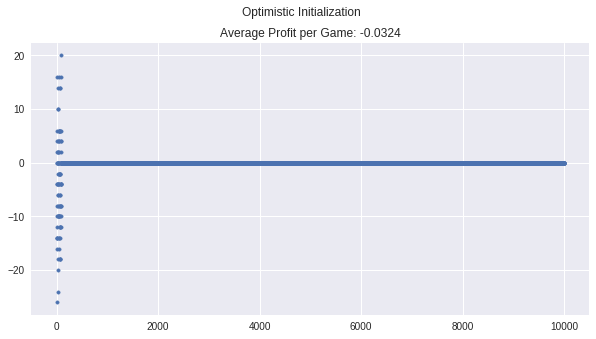

In [40]:
pol = optInitPolicy()
getResults(pol, "Optimistic Initialization")

Actions taken by agent in different rounds


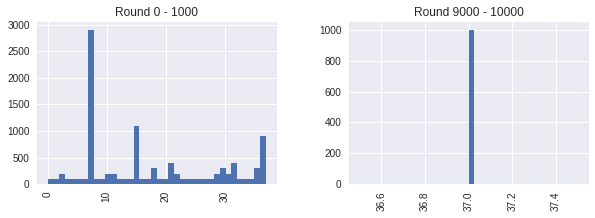

In [41]:
plotActions(pol)

In [42]:
del(pol)

## Optimism in  the Face of Uncertainty

Our policies so far haven't implemented a clever way to explore our action space. They just followed random actions. 

We can do better. To give some intuition, consider the following two action histories:

- Number 7 yielded \$1 once, and \$-1 twice.
- Number 8 yielded \$1 100 times, and \$-1 200 times.

The average return is the same for both cases (-0.33). However, we're a lot more confident that number 8 has a negative reward, since we played it 100 times more. Number 7 could have just had a few unlucky flips.

Thus, we will favor uncertain actions. In the above example, we favor 7. If 7 is indeed a bad number, successive trials will prove it.

We select a **p** such that an action not chosen is at most **p** percent likely to be the optimal one. We then use [Hoeffding's Inequality](https://en.wikipedia.org/wiki/Hoeffding%27s_inequality#Special_case_of_Bernoulli_random_variables) to choose our action according to 

$$ argmax  (Q(s, a) + H(s, a)) $$

where H is a measure of uncertainty. In the case of bernoulli random variables, it would be equal to 

$$ H(s, a) = \sqrt{\frac{-log(p)}{2n_{sa}}} $$

where $n_{sa}$ is the frequency of the given state-action pair.

In our case, the formula doesn't quite work, as **0** isn't a [0, 1] (or [-1, 1]) variable. It will reduce the uncertainty in the probability that a number appears, but it won't reduce the uncertainty in the expected value (which is what we care about).

Usually it is not a bad approach (unless the payoff distribution is extremely skewed), as in this case.

Benefits
- Explores the action space intelligently, by favoring actions with uncertain payoffs.
- Hypterparameter has a meaningful interpretation.

Drawbacks
- Formula is only exact for [0, 1] binary variables.
- Doesn't handle highly skewed payoffs well.

In [43]:
class optUnc(Policy):
    
    def __init__(self, p = 0.05):
        super().__init__()
        self.H = np.ones(self.Q.shape)
        self.H[0, 37] = 0
        self.p = p
        
    def pi(self):
        Q = self.Q[self.state, :]
        H = self.H[self.state, :]
        return np.argmax(Q+H)
        
    def updateH(self):
        for s in range(self.nS):
            for a in range(self.nA):
                if (not self.returns[(s, a)] == []) & (a != 37):
                    n = len(self.returns[(s, a)])
                    self.H[s, a] = np.sqrt(-np.log(self.p)/(2 * n))
             
    def callOnEnd(self):
        self.updateH()

Voila: after only few rounds of exploring, we find the best policy.

..........



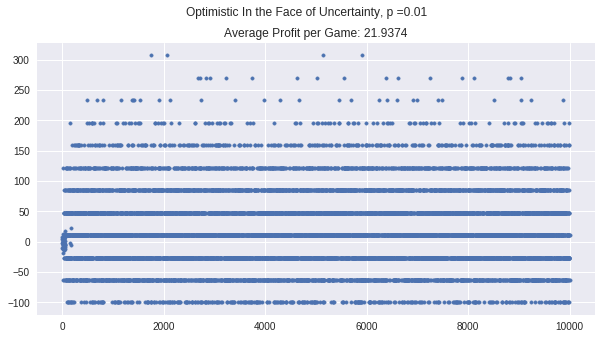

In [44]:
pol = optUnc(p = 0.01)
getResults(pol, 'Optimistic In the Face of Uncertainty, p =0.01')

## Thompson Sampling

Here is another way to intelligently expore t: let's sample actions by the probability that they are optimal. This way, actions that had good historical returns will be favored, but we will also occasionally sample actions that didn't have good returns. 

Specifically, we will assume a prior distribution for the expected payoff for each number. In this example, we use a Beta distribution with parameters (1, 1). Then, as we collect rewards, we update these parameters.

Then, in each round, we take a sample from the distribution of each action. We choose the action with the highest sample.

Benefits
- Intelligently explores the action space.

Drawbacks
- Doesn't handle data skew well (at least not with a beta prior).

In [79]:
class ThompSamp(Policy):
    
    def __init__(self):
        super().__init__()
        self.alphas = np.ones(self.Q.shape)
        self.betas = np.ones(self.Q.shape)
        
    def pi(self):
        
        s = self.state
        n = self.alphas[s, :].shape[0]
        sampl = np.ones(n)/2
        for i in range(n - 1):
            sampl[i] = np.random.beta(self.alphas[s, i], self.betas[s, i])
        self.current_action = np.argmax(sampl)
        return self.current_action
             
    def callOnEnd(self):
        for state, action, G in self.states_actions_returns:
            if G > 0:
                self.alphas[state, action] += G
            elif self.reward < 0:
                self.betas[state, action] += -G

This graph is interesting. Only towards the second half does the agent swing to the optimal policy. The likely reason: until then zeros didn't have a good track record (remember, they only come up once in 30 turns on average). Not having a good track record made it less likely that they got selected.

However, by (weighted) random sampling, every now and then we did select a zero. And one success had a major update on distribution weights. Zeros got selected more and more often, and a positive cascade got built.

..........



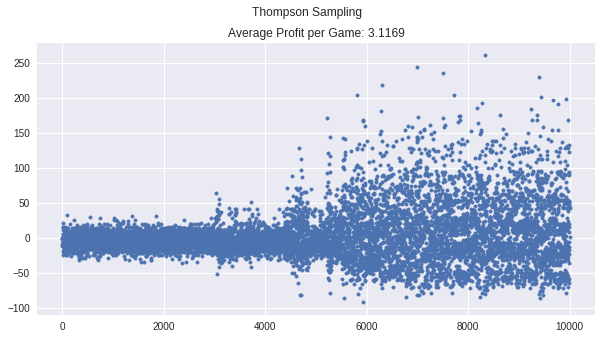

In [80]:
pol = ThompSamp()
getResults(pol, 'Thompson Sampling')

Actions taken by agent in different rounds


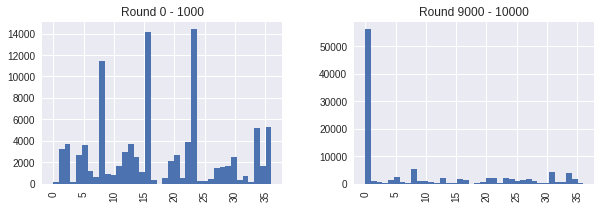

In [81]:
plotActions(pol)